In [1]:
import json
import re
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import stanza
from pathlib import Path

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stanza.download('en')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/raquelpanadero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raquelpanadero/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raquelpanadero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-10-29 10:44:52 INFO: Downloaded file to /home/raquelpanadero/stanza_resources/resources.json
2024-10-29 10:44:52 INFO: Downloading default packages for language: en (English) ...
2024-10-29 10:44:53 INFO: File exists: /home/raquelpanadero/stanza_resources/en/default.zip
2024-10-29 10:44:56 INFO: Finished downloading models and saved to /home/raquelpanadero/stanza_resources


In [3]:
# Get the current file's directory and project root
CURRENT_DIR = Path().absolute()
PROJECT_ROOT = CURRENT_DIR.parent
ANNOTATION_FILE_PATH = PROJECT_ROOT / 'data' / 'EN' / 'subtask-2-annotations.txt' # we work only in English for now
DATA_PATH = PROJECT_ROOT / 'data' / 'EN' / 'raw-documents'

## Most frequent words

In [4]:
class WordFrequencyAnalyzer:
    def __init__(self):          
        # Get stopwords from NLTK and Stanza
        self.nltk_stopwords = set(stopwords.words('english'))
        
        # Additional common words to filter
        self.additional_stopwords = {
            'said', 'would', 'could', 'also', 'one', 'two', 'three',
            'first', 'second', 'third', 'new', 'time', 'year', 'years',
            'many', 'much', 'may', 'might', 'must', 'like', 'well'
        }
        
        self.all_stopwords = self.nltk_stopwords.union(self.additional_stopwords)

    def process_file(self, file_path):
        """Process a single file and return word frequencies with and without stopwords."""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().lower()  # Convert to lowercase
            
            # NLTK tokenization
            tokens = word_tokenize(text)
            
            # Remove punctuation and numbers
            words = [word for word in tokens if word.isalpha()]
            
            # Create two frequency distributions
            freq_with_stops = Counter(words)
            freq_without_stops = Counter(
                word for word in words if word not in self.all_stopwords
            )
            
            return {
                'with_stops': freq_with_stops,
                'without_stops': freq_without_stops,
                'total_words': len(words)
            }
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def analyze_directory(self, data_dir: str):
        """Analyze all text files in the directory."""
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Directory not found: {data_path}")

        # Initialize counters for different file types
        cc_frequencies = {'with_stops': Counter(), 'without_stops': Counter()}
        ua_frequencies = {'with_stops': Counter(), 'without_stops': Counter()}
        
        # Statistics
        stats = {
            'CC': {'files': 0, 'total_words': 0},
            'UA': {'files': 0, 'total_words': 0}
        }

        # Process each file
        for file_path in data_path.glob('*.txt'):
            results = self.process_file(file_path)
            if results:
                # Determine file type
                filename = file_path.name
                if 'CC' in filename:
                    file_type = 'CC'
                    target_freq = cc_frequencies
                elif 'UA' in filename:
                    file_type = 'UA'
                    target_freq = ua_frequencies
                else:
                    continue  # Skip files that don't match either pattern

                # Update statistics
                stats[file_type]['files'] += 1
                stats[file_type]['total_words'] += results['total_words']
                
                # Update frequencies
                target_freq['with_stops'].update(results['with_stops'])
                target_freq['without_stops'].update(results['without_stops'])

        # Create DataFrames for top 20 words
        def create_freq_df(counter: Counter, label: str):
            df = pd.DataFrame.from_records(
                counter.most_common(20),
                columns=['word', 'frequency']
            )
            df['source'] = label
            return df

        # Create separate DataFrames for CC and UA
        cc_with_stops = create_freq_df(cc_frequencies['with_stops'], 'Climate Change')
        cc_without_stops = create_freq_df(cc_frequencies['without_stops'], 'Climate Change')
        ua_with_stops = create_freq_df(ua_frequencies['with_stops'], 'Ukraine-Russia War')
        ua_without_stops = create_freq_df(ua_frequencies['without_stops'], 'Ukraine-Russia War')

        # Combine DataFrames
        with_stops_df = pd.concat([cc_with_stops, ua_with_stops])
        without_stops_df = pd.concat([cc_without_stops, ua_without_stops])

        return stats, with_stops_df, without_stops_df

    def plot_comparisons(self, with_stops_df: pd.DataFrame, without_stops_df: pd.DataFrame):
        """Create comparison plots for word frequencies."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

        # Plot frequencies with stopwords
        sns.barplot(data=with_stops_df, x='frequency', y='word', hue='source', ax=ax1)
        ax1.set_title('Top 20 Words (Including Stopwords)')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Word')

        # Plot frequencies without stopwords
        sns.barplot(data=without_stops_df, x='frequency', y='word', hue='source', ax=ax2)
        ax2.set_title('Top 20 Words (Excluding Stopwords)')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Word')

        plt.tight_layout()
        plt.show()


File Statistics:

CC Files:
Number of files: 72
Total words processed: 32,996

UA Files:
Number of files: 128
Total words processed: 65,152


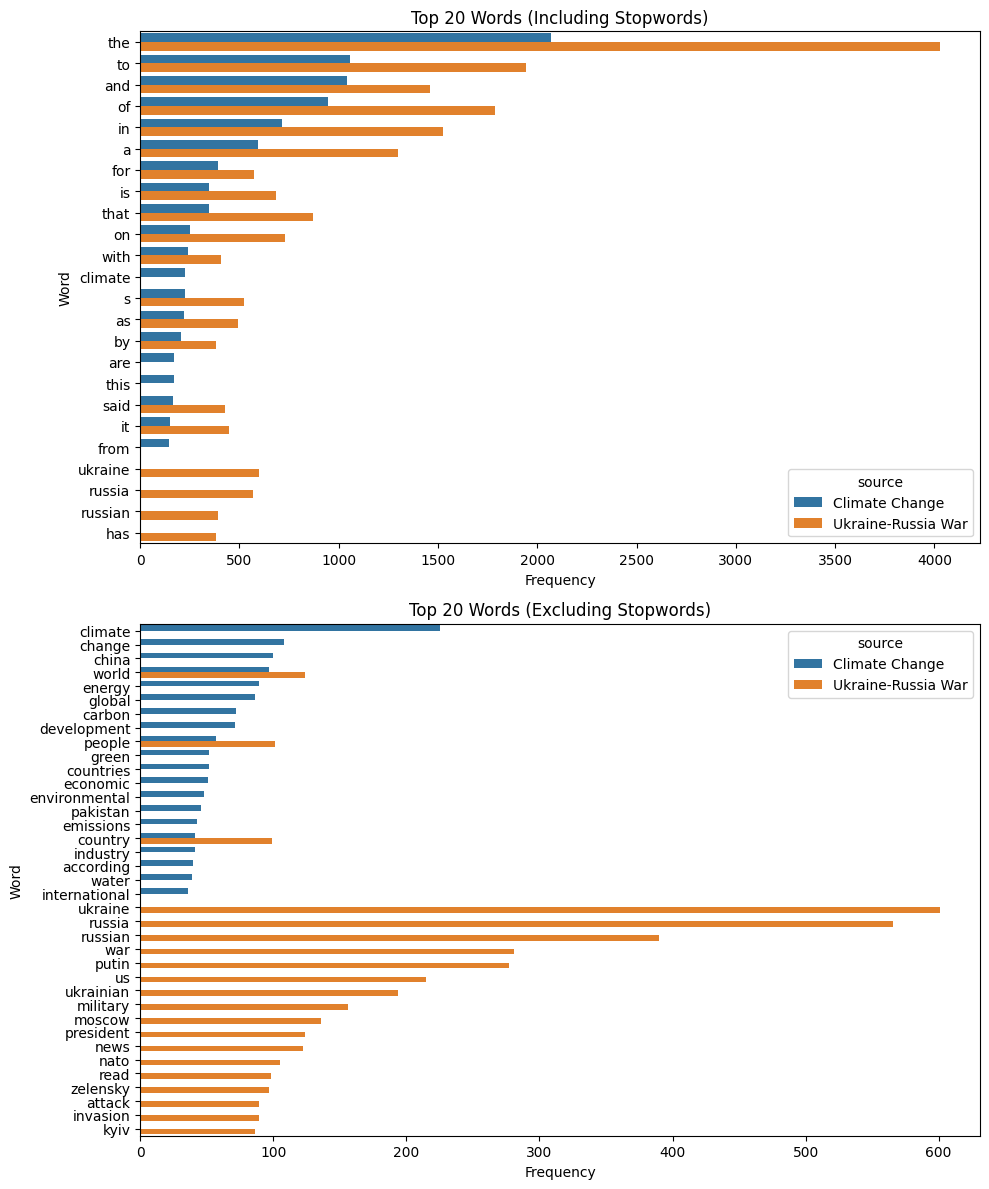

In [5]:
analyzer = WordFrequencyAnalyzer()
data_dir = "data"  # Adjust path as needed
stats, with_stops_df, without_stops_df = analyzer.analyze_directory(DATA_PATH)

# Print statistics
print("\nFile Statistics:")
for file_type, file_stats in stats.items():
    print(f"\n{file_type} Files:")
    print(f"Number of files: {file_stats['files']}")
    print(f"Total words processed: {file_stats['total_words']:,}")

# Create visualizations
analyzer.plot_comparisons(with_stops_df, without_stops_df)

## Irrelevant words to remove

In [11]:
class BoilerplateAnalyzer:
    def __init__(self):
        # Common boilerplate patterns to search for
        self.boilerplate_patterns = {
            'read_more': r'read more|most read|read all the|continue reading', # this is usually a short line, discard line
            'un_subscribe': r'subscribe to|join our list|unsubscribe|sign_up|register_for', # this is usually a short line, discard line
            'follow_us': r'follow us', # this is usually a short line, discard line
            'click_here': r'click here', # this is usually a short line, discard line
            'share': r'share this', # this is usually a short line, discard line
            'publish_date': r'published on', # this is usually a short line, discard line
            'copyright': r'copyright', # this is usually a short line, discard line
            'watch_video': r'watch this video|watch the interview|this video is from', # this is usually a short line, discard line
            'watch_more': r'watch more|watch the full|must watch', # this is usually a short line, discard line
            'find out more': r'find out more|continue at [a-z].[a-z]{1,3}', # this is usually a short line, discard line
            'social_media': r'twitter|instagram|facebook|telegram', # don't do anything, will be handled case by case
            '@': r'@', # will be handled case by case
            'news_company': r'[A-Z][a-z]+(?: [A-Z][a-z]+)* News',
            'press_company': r'[A-Z][a-z]+(?: [A-Z][a-z]+)* Press',
            'latest_video': r'latest video', # this is usually a short line, discard line
            'terms_of_use': r'terms of use', # this is usually a short line, discard line
            'about_the_writer': r'about the writer', # nothing useful after this
            'share_your_thougths': r'share your', # nothing useful after this,
            'urls': r'https?:\/\/[^\s]+', # this is usually a short line, discard line
            'join_contribute': r'Anyone can join.\n\nAnyone can contribute.\n\n', # weird propaganda, nothing useful after this,
            'ads': r'We pay for your stories!', # nothing useful after this, 
            'twitter_x_timestamps': r'[—-] .+? \(@[\w]+\) (?:January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2}, \d{4}', # replace with nothing
            'journalist': r"[Bb]y (?:[A-Z][a-zA-Z\-']+ [A-Z][a-zA-Z\-']+, [A-Z][a-zA-Z\s]+ News:|[A-Z][a-zA-Z\-']+ [A-Z][a-zA-Z\-']+ of [A-Z][a-zA-Z\s]+ News)", # this is usually a short line, discard line
            'top_stories': r"top stories curated by", # this is usually a short line, discard line
            "twitter_pics": r"pic.twitter.com/[a-zA-Z0-9]+", # replace with nothing
            "make_donation": r"make a donation|donation buttons", # # this is usually a short line, discard line
            "fact_check": r"fact check", # replace with nothing
        }
        
        # Compile patterns for efficiency
        self.compiled_patterns = {
            name: re.compile(pattern, re.IGNORECASE) if '[A-Z]' not in pattern else re.compile(pattern)
            for name, pattern in self.boilerplate_patterns.items()
        }

    def analyze_file(self, file_path: Path):
        """Analyze a single file for boilerplate patterns."""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            results = {
                'filename': file_path.name,
                'total_lines': len(content.splitlines()),
                'total_chars': len(content),
                'matches': defaultdict(list)
            }

            # Find all matches for each pattern
            for name, pattern in self.compiled_patterns.items():
                matches = pattern.finditer(content)
                for match in matches:
                    results['matches'][name].append({
                        'text': match.group().strip(),
                        'position': match.start()
                    })

            return results
        
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def analyze_directory(self, data_dir: str):
        """Analyze all text files in the directory."""
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Directory not found: {data_path}")

        all_results = []
        total_stats = defaultdict(int)
        pattern_locations = defaultdict(list)
        
        # Process each file
        for file_path in data_path.glob('*.txt'):
            results = self.analyze_file(file_path)
            if results:
                all_results.append(results)
                
                # Update total statistics
                total_stats['total_files'] += 1
                total_stats['total_lines'] += results['total_lines']
                total_stats['total_chars'] += results['total_chars']
                
                # Count pattern matches
                for pattern_name, matches in results['matches'].items():
                    total_stats[f'{pattern_name}_count'] += len(matches)
                    for match in matches:
                        pattern_locations[pattern_name].append(
                            match['position'] / results['total_chars']  # Normalize position
                    )
        
        # Create summary DataFrame
        summary_data = []
        for pattern_name in self.boilerplate_patterns.keys():
            count = total_stats.get(f'{pattern_name}_count', 0)
            avg_position = (
                sum(pattern_locations[pattern_name]) / len(pattern_locations[pattern_name])
                if pattern_locations[pattern_name] else 0
            )
            
            summary_data.append({
                'pattern': pattern_name,
                'total_occurrences': count,
                'files_percentage': (count / total_stats['total_files'] * 100) if total_stats['total_files'] > 0 else 0,
                'avg_relative_position': avg_position
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('total_occurrences', ascending=False)

        return summary_df, total_stats

    def plot_statistics(self, summary_df, total_stats):
        """Plot analysis results."""
        plt.figure(figsize=(8, 5))
        plt.barh(summary_df['pattern'], summary_df['files_percentage'])
        plt.title('Percentage of Files Containing Each Boilerplate Pattern')
        plt.xlabel('Percentage of Files (%)')
        plt.ylabel('Pattern Type')
        plt.tight_layout()
        plt.show()
        


Overall Statistics:
Total files analyzed: 200
Total lines processed: 6,961
Total characters processed: 631,377

Boilerplate Pattern Summary:


,pattern,total_occurrences,files_percentage,avg_relative_position
10,social_media,105,52.5,0.669872
0,read_more,87,43.5,0.654623
12,news_company,68,34.0,0.736518
11,@,49,24.5,0.656091
18,urls,30,15.0,0.447236
21,twitter_x_timestamps,29,14.5,0.598013
24,twitter_pics,20,10.0,0.623057
1,un_subscribe,14,7.0,0.586759
2,follow_us,11,5.5,0.983755
26,fact_check,11,5.5,0.158221


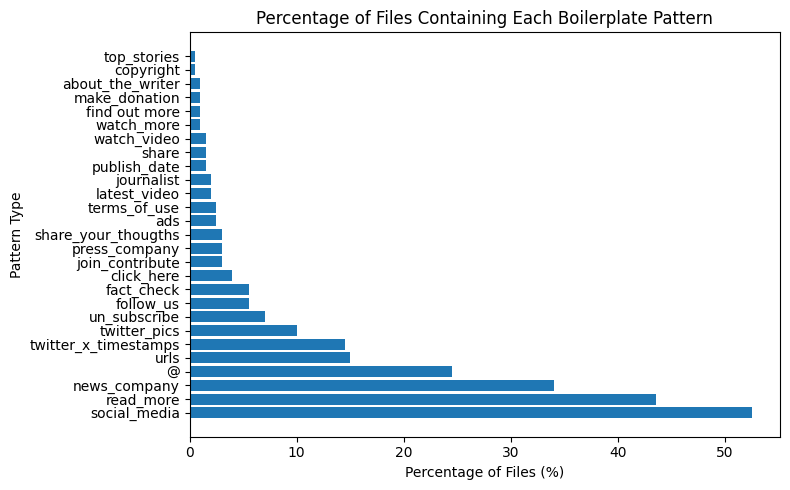

In [12]:
analyzer = BoilerplateAnalyzer()
data_dir = "data"  # Adjust path as needed
summary_df, total_stats = analyzer.analyze_directory(DATA_PATH)

# Print statistics
print("\nOverall Statistics:")
print(f"Total files analyzed: {total_stats['total_files']}")
print(f"Total lines processed: {total_stats['total_lines']:,}")
print(f"Total characters processed: {total_stats['total_chars']:,}")

# Display summary DataFrame
print("\nBoilerplate Pattern Summary:")
display(summary_df)

# Plot results
analyzer.plot_statistics(summary_df, total_stats)

In [13]:
def search_text(pattern, b=20, a=20):
    for file_path in DATA_PATH.glob('*.txt'):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        if '[A-Z]' in pattern:   
            match = re.search(pattern, text)
        else:
            match = re.search(pattern, text, re.IGNORECASE)
        if match is None:
            continue
        i, j = match.span()
        start = max(i-b, 0)
        end = j+a
        print(f"{file_path.name}:\t{text[start:end]}\n\n")

def search_by_line(pattern):
    pattern = (re.compile(pattern, re.IGNORECASE)
                if "[A-Z]" not in pattern
                else re.compile(pattern))
    
    for file_path in DATA_PATH.glob('*.txt'):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        lines = text.split("\n")
        for line in lines:
            if pattern.search(line):
                print(f"{file_path.name}:\t{line}\n\n")

In [193]:
search_text(r'about the writer', a=2000) # after "About the Writer", there is no useful information

EN_UA_010735.txt:	nergy for comment.

About the writer

Andrew Stanton is a Newsweek weekend reporter based in Maine. His role is reporting on U.S. politics and social issues. Andrew joined Newsweek in 2021 from The Boston Globe. He is a graduate of Emerson College. You can get in touch with Andrew by emailing a.stanton@newsweek.com. Languages: English.

Andrew Stanton is a Newsweek weekend reporter based in Maine. His role is reporting on U.S. politics and social issues. ... Read more


EN_UA_002531.txt:	D.C., for comment.

About the writer

Aila Slisco is a Newsweek night reporter based in New York. Her focus is on reporting national politics, where she has covered the 2020 and 2022 elections, the impeachments of Donald Trump and multiple State of the Union addresses. Other topics she has reported on for Newsweek include crime, public health and the emergence of COVID-19. Aila was a freelance writer before joining Newsweek in 2019. You can get in touch with Aila by emailing a.slisco@

In [15]:
search_by_line(r"fact check") #

EN_CC_100036.txt:	FACT CHECK: Is NASA Planning To Blast Ice Particles Into The Atmosphere To Fight Climate Change? 


EN_CC_100036.txt:	 FACT CHECK: Is NASA Planning To Blast Ice Particles Into The Atmosphere To Fight Climate Change?


EN_CC_100036.txt:	Fact Check:


EN_CC_100091.txt:	FACT CHECK: Did Greta Thunberg Say Saving The Banks Would Save The World? 


EN_CC_100091.txt:	 FACT CHECK: Did Greta Thunberg Say Saving The Banks Would Save The World?


EN_CC_100091.txt:	Fact Check:


EN_CC_100076.txt:	Reuters Joins BBC in Failed ‘Fact Check’ of Daily Sceptic Arctic Sea Ice Story 


EN_CC_100076.txt:	Read more: Reuters Joins BBC in Failed ‘Fact Check’ of Daily Sceptic Arctic Sea Ice Story


EN_CC_100028.txt:	FACT CHECK: Viral X Image Purporting To Show Greta Thunberg Holding Anti-Semitic Book Is Digitally Altered 


EN_CC_100028.txt:	 FACT CHECK: Viral X Image Purporting To Show Greta Thunberg Holding Anti-Semitic Book Is Digitally Altered


EN_CC_100028.txt:	Fact Check:




## Text segmentation and normalizaton

In [157]:
nlp = stanza.Pipeline('en', processors='tokenize,lemma,pos')

2024-10-23 10:44:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-23 10:44:17 INFO: Downloaded file to /home/raquelpanadero/stanza_resources/resources.json
2024-10-23 10:44:17 WARNING: Language en package default expects mwt, which has been added
2024-10-23 10:44:18 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-10-23 10:44:18 INFO: Using device: cuda
2024-10-23 10:44:18 INFO: Loading: tokenize
/home/raquelpanadero/.pyenv/versions/3.9.16/lib/python3.9/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [170]:
import os, random
file_path = DATA_PATH / 'EN_UA_026142.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

In [173]:
text

'Oppose imperialist War! SEP/IYSSE public meeting in Sri Lanka \n\n The Socialist Equality Party (SEP) and the International Youth and Students for Social Equality (IYSSE) in Sri Lanka are holding an online meeting entitled “Oppose imperialist war!” on Thursday, May 23, at 7pm.\n\nIn announcing the recent International May Day Rally, David North, chairman of the International Editorial Board of the World Socialist Web Site, warned, “A third world war is not a distant possibility. The opening stages of this war are already underway.”\n\nIsrael’s genocide in Gaza against Palestinians and its US-backed attacks against Iran are just one front in a rapidly emerging world war involving nuclear armed powers. US imperialism and its allies are already engaged in a war against Russia in Ukraine and are making advanced preparations for a catastrophic conflict with China.\n\nThe imperialist leaders as well as various media pundits now casually refer to a nuclear war as an acceptable strategic opti

In [171]:
doc = nlp(text)

In [174]:
for sentence in doc.sentences[5:]:
    for word in sentence.words:
        print(word.text + '\t' + word.lemma)
    print()

Israel	Israel
’s	's
genocide	genocide
in	in
Gaza	Gaza
against	against
Palestinians	Palestinian
and	and
its	its
US	US
-	-
backed	back
attacks	attack
against	against
Iran	Iran
are	be
just	just
one	one
front	front
in	in
a	a
rapidly	rapidly
emerging	emerge
world	world
war	war
involving	involve
nuclear	nuclear
armed	armed
powers	power
.	.

US	US
imperialism	imperialism
and	and
its	its
allies	ally
are	be
already	already
engaged	engage
in	in
a	a
war	war
against	against
Russia	Russia
in	in
Ukraine	Ukraine
and	and
are	be
making	make
advanced	advanced
preparations	preparation
for	for
a	a
catastrophic	catastrophic
conflict	conflict
with	with
China	China
.	.

The	the
imperialist	imperialist
leaders	leader
as	as
well	well
as	as
various	various
media	media
pundits	pundit
now	now
casually	casually
refer	refer
to	to
a	a
nuclear	nuclear
war	war
as	as
an	a
acceptable	acceptable
strategic	strategic
option	option
,	,
despite	despite
the	the
grave	grave
threat	threat
it	it
poses	pose
to	to
the	the
existenc